## <font color='red'>Projeto: Prevenção da Manutenção de Máquinas Industriais</font>

https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

In [1]:
# Imports
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import warnings
import pkg_resources
warnings.filterwarnings('ignore')

In [2]:
# Carregando base de dados
df = pd.read_csv('predictive_maintenance.csv')

In [3]:
df.shape

(10000, 10)

In [4]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


## <font color='red'>Parte 1: Limpeza e Tratamento de Dados</font>

In [5]:
# Verificando onde deu problema na máquina
df[df['Target'] == 1].sample(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
3865,3866,H33279,H,302.6,311.5,1629,34.4,228,1,Tool Wear Failure
1437,1438,H30851,H,298.8,309.9,1439,45.2,40,1,No Failure
5399,5400,H34813,H,302.8,312.4,1411,53.8,246,1,Overstrain Failure
5941,5942,L53121,L,300.6,310.7,1438,48.5,78,1,No Failure
1833,1834,L49013,L,297.8,307.3,1327,61.0,186,1,Overstrain Failure


In [6]:
'''
O foco do projeto não será verificar o tipo de falha que a máquina teve, mas sim se apenas houve ou não alguma falha. Sendo assim a coluna Failure Type
será removida. A coluna UDI também será removida pois não apresenta informações relevantes assim como a coluna Product ID.
'''
columns_to_drop = ['UDI', 'Product ID', 'Failure Type']

df.drop(columns = columns_to_drop, inplace = True)

In [7]:
df.head(2)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0


In [8]:
# Alterando nome das colunas
df.rename(columns = {'Type': 'type',
                      'Air temperature [K]': 'air_temperature[K]',
                      'Process temperature [K]': 'process_temperature[K]',
                      'Rotational speed [rpm]': 'rotational_speed[rpm]',
                      'Torque [Nm]': 'torque[NM]',
                      'Tool wear [min]': 'tool_wear[min]',
                      'Target': 'target'}, inplace = True)

In [9]:
# Verificar valores ausentes
def missing_values(df):
    missing_values = df.isna().sum()
    percentage = (missing_values / len(df)).apply(lambda x:'{:.2%}'.format(x))
    return pd.DataFrame({'Missing Values': missing_values,
                         'Percentage': percentage})

In [10]:
missing_values(df)

,Missing Values,Percentage
type,0,0.00%
air_temperature[K],0,0.00%
process_temperature[K],0,0.00%
rotational_speed[rpm],0,0.00%
torque[NM],0,0.00%
tool_wear[min],0,0.00%
target,0,0.00%


## <font color='red'>Parte 2: Mapeamento da Coluna Type</font>

In [11]:
# Será alterado os valores da coluna type para valores numéricos
# Definir o mapeamento fixo
type_mapping = {'L': 1, 'M': 2, 'H': 3}

# Aplicar o mapeamento ao DataFrame
df['type'] = df['type'].map(type_mapping)

## <font color='red'>Parte 3: Padronização dos Dados</font>

In [12]:
# Cria o padronizador
scaler = StandardScaler()

In [13]:
# Criar novo df sem a variável alvo
dados = df.drop(columns=['target'])

dados.head(5)

In [14]:
# Aplicando o padronizador
dados_padronizados = scaler.fit_transform(dados)

In [15]:
dados_padronizados

array([[ 0.74441274, -0.95238944, -0.94735989,  0.06818514,  0.28219976,
        -1.69598374],
       [-0.74530658, -0.90239341, -0.879959  , -0.72947151,  0.63330802,
        -1.6488517 ],
       [-0.74530658, -0.95238944, -1.01476077, -0.22744984,  0.94428963,
        -1.61743034],
       ...,
       [ 0.74441274, -0.50242514, -0.94735989,  0.59251888, -0.66077672,
        -1.35034876],
       [ 2.23413206, -0.50242514, -0.879959  , -0.72947151,  0.85400464,
        -1.30321671],
       [ 0.74441274, -0.50242514, -0.879959  , -0.2162938 ,  0.02137647,
        -1.22466331]])

## <font color='red'>Parte 4: Aplicando PCA</font>

In [16]:
# Criar modelo
pca = PCA()

In [17]:
# Treina e aplica o modelo aos dados padronizados
dados_pca = pca.fit_transform(dados_padronizados)

In [18]:
dados_pca

array([[-1.10818884,  0.86238991,  1.6811689 , -0.67610376,  0.20104347,
         0.15385387],
       [-1.59152716,  0.19918311,  0.59618165, -1.69192891, -0.06677308,
        -0.02993335],
       [-1.58877637,  0.38501522,  0.56870922, -1.67326399,  0.4279888 ,
         0.27000025],
       ...,
       [-0.15163569,  1.38073468,  1.44836204, -0.43164935,  0.15644685,
        -0.27793409],
       [-1.53819592, -0.06849842,  2.46814016,  0.65592242,  0.24614037,
        -0.15702693],
       [-0.85056268,  0.59010626,  1.36019413, -0.34063003,  0.05685997,
        -0.29474932]])

## <font color='red'>Parte 5: Criando Matriz de Covariância</font>

In [19]:
# Calcula a matriz de Covariância 
cov_matrix = np.cov(dados_padronizados, rowvar = False)
cov_matrix

array([[ 1.00010001e+00, -1.51779310e-02, -1.21020974e-02,
        -3.97976197e-03, -3.09694241e-03, -7.25577816e-03],
       [-1.51779310e-02,  1.00010001e+00,  8.76194778e-01,
         2.26727261e-02, -1.37792010e-02,  1.38542131e-02],
       [-1.21020974e-02,  8.76194778e-01,  1.00010001e+00,
         1.92786418e-02, -1.40620193e-02,  1.34888660e-02],
       [-3.97976197e-03,  2.26727261e-02,  1.92786418e-02,
         1.00010001e+00, -8.75114598e-01,  2.23107151e-04],
       [-3.09694241e-03, -1.37792010e-02, -1.40620193e-02,
        -8.75114598e-01,  1.00010001e+00, -3.09309075e-03],
       [-7.25577816e-03,  1.38542131e-02,  1.34888660e-02,
         2.23107151e-04, -3.09309075e-03,  1.00010001e+00]])

In [20]:
# Extrai a variância explicada
explained_variance = pca.explained_variance_ratio_
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

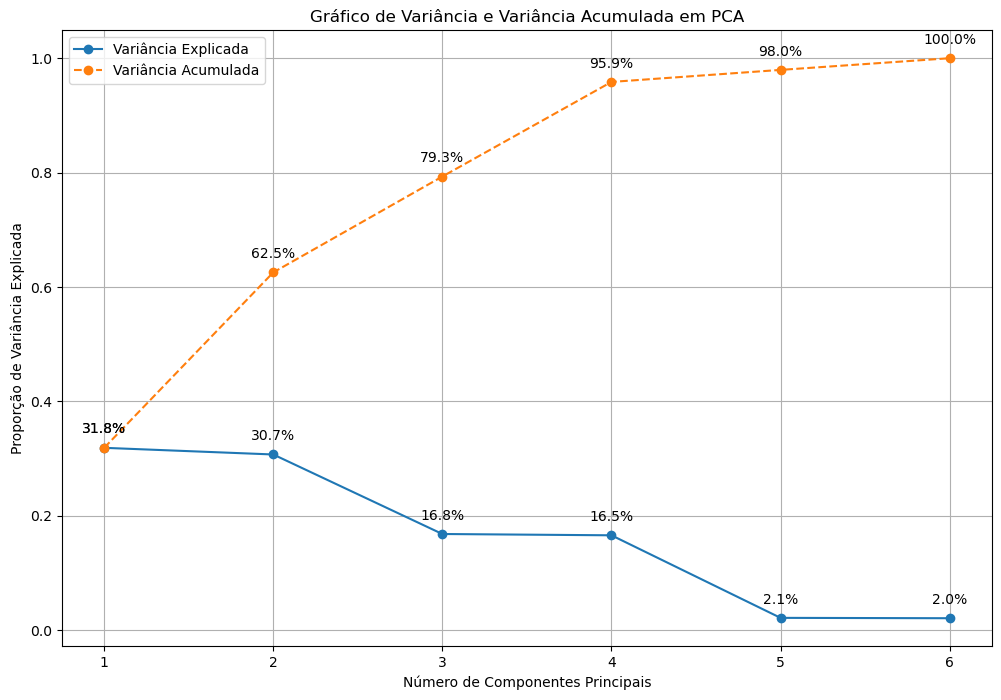

In [21]:
# Gráfico para verificar as variâncias

#Plot
plt.figure(figsize=(12, 8))
x = range(1, len(var_explicada) + 1)
plt.plot(x, var_explicada, marker='o', label='Variância Explicada')
plt.plot(x, var_acumulada, marker='o', label='Variância Acumulada', linestyle='--')

# Adicionar anotações para variância explicada
for i in range(len(var_explicada)):
    plt.text(x[i], var_explicada[i] + 0.02, f'{var_explicada[i]*100:.1f}%', ha='center', va='bottom')

# Adicionar anotações para variância acumulada
for i in range(len(var_acumulada)):
    plt.text(x[i], var_acumulada[i] + 0.02, f'{var_acumulada[i]*100:.1f}%', ha='center', va='bottom')

plt.title('Gráfico de Variância e Variância Acumulada em PCA')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Proporção de Variância Explicada')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()

## <font color='red'>Parte 6: Interpretação de Componentes</font>

In [22]:
# Extraindo os componentes principais
componentes = pd.DataFrame(pca.components_, 
                           columns = dados.columns, 
                           index = [f'PC-{i}' for i in range(1, 7)])

In [23]:
componentes

,type,air_temperature[K],process_temperature[K],rotational_speed[rpm],torque[NM],tool_wear[min]
PC-1,-0.015803,0.507144,0.506251,0.494951,-0.490913,0.017121
PC-2,0.015585,-0.492263,-0.493147,0.504922,-0.509013,-0.014145
PC-3,0.707568,0.020791,0.023552,-0.000698,-0.002335,-0.705942
PC-4,0.706269,-0.001091,0.001132,-0.005028,-0.003076,0.707917
PC-5,0.006012,0.424889,-0.429354,0.563174,0.563845,0.001793
PC-6,0.001430,-0.565259,0.561797,0.427652,0.426585,0.001695


A tabela acima mostra os coeficientes (ou cargas) de cada componente principal em relação a cada um dos atributos originais. Cada linha (PC-1, PC-2, etc.) representa um componente principal, e cada valor na linha indica a contribuição relativa de cada atributo original para esse componente principal. Aqui está como você pode interpretar esses valores:

**PC-1, PC-2, ..., PC-6**: Estes são os componentes principais obtidos da PCA. Cada componente é uma combinação linear dos atributos originais.

**Os valores na tabela mostram como cada atributo original contribui para o componente principal correspondente. Um valor alto (positivo ou negativo) indica uma contribuição significativa desse atributo ao componente principal, enquanto um valor próximo de zero indica pouca ou nenhuma contribuição.

Como interpretar cada componente:

**PC-1**: Tem altas cargas (em magnitude) para as variáveis air_temperature[K], process_temperature[K], rotational_speed[rpm] e torque[NM], indicando que esses atributos são importantes para este componente. Os sinais opostos (positivo e negativo) podem indicar correlações inversas entre estes atributos no contexto deste componente.

## <font color='red'>Parte 7: Escolhendo o Número Ideal de Componentes com Validação Cruzada</font>

In [24]:
# Lista para armazenar o SSE
sse = []

# Range de valores de k a serem testados
k_range = range(1, 7)

# Testando os valores
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(componentes)
    sse.append(kmeans.inertia_)

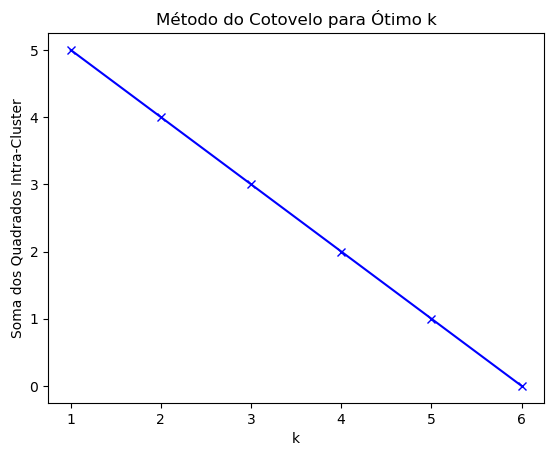

In [25]:
# Plot
plt.plot(k_range, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo para Ótimo k')
plt.show()

In [26]:
scores = []

In [27]:
# Loop sobre o número de componentes do PCA de 1 a 6
for i in range(1, 7):
    
    # Cria um objeto PCA com i componentes
    pca = PCA(n_components = i)
    
    # Ajusta o PCA aos dados escalonados e transforma os dados
    pca_data = pca.fit_transform(dados_padronizados)
    
    # Cria um objeto de regressão logística
    lr = LogisticRegression()
    
    # Avalia a regressão logística usando validação cruzada e calcula a média das pontuações
    score = cross_val_score(lr, pca_data, df['target'], cv = 5).mean()
    
    # Adiciona a média das pontuações à lista de pontuações
    scores.append(score)

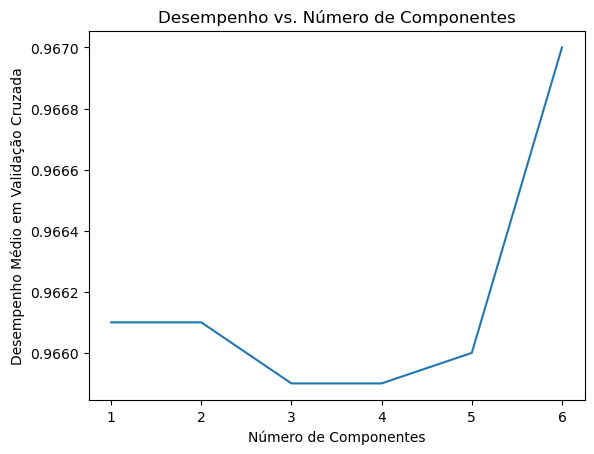

In [28]:
# Plot
plt.plot(range(1, 7), scores)
plt.xlabel('Número de Componentes')
plt.ylabel('Desempenho Médio em Validação Cruzada')
plt.title('Desempenho vs. Número de Componentes')
plt.show()

## <font color='red'>Parte 8: LOOCV - Leave One Out Cross-Validation</font>

O LOOCV (Leave-One-Out Cross-Validation) é uma técnica de validação cruzada onde cada amostra do dataset é usada como conjunto de teste exatamente uma vez, enquanto as amostras restantes são usadas para treinar o modelo. Em outras palavras, se você tem um dataset com n amostras, o modelo é treinado n vezes, cada vez com n-1 amostras e testado em uma amostra diferente. A métrica de desempenho, como a acurácia, é calculada para cada uma das n iterações e a média dessas métricas fornece a avaliação final do modelo.

In [29]:
# Aplicando o LOOCV
loo = LeaveOneOut()
lr = LogisticRegression()
scores_loo = cross_val_score(lr, pca_data, df['target'], cv = loo)
print(f"LOOCV Score: {scores_loo.mean()}")

LOOCV Score: 0.9696


O LOOCV Score: 0.9696 indica que a média das pontuações obtidas em todas as iterações do LOOCV é 0.9696, o que sugere que o modelo tem uma acurácia média de aproximadamente 96.96% na previsão correta das amostras de teste.

## <font color='red'>Parte 9: Modelo Final</font>

In [30]:
# Para o modelo final será usado 4 componentes principais
pca_final = PCA(n_components = 4)
pca_data_final = pca_final.fit_transform(dados_padronizados)
modelo_lr_final = LogisticRegression()
modelo_lr_final.fit(pca_data_final, df['target'])

LogisticRegression()

## <font color='red'>Parte 10: Testando Novos Dados</font>

In [31]:
# # Simulando novos dados de sensores de uma máquina industrial
dados = {
    'type': [np.random.choice(['L', 'M', 'H'])],
    'air_temperature[K]': [np.random.uniform(295, 305)],
    'process_temperature[K]': [np.random.uniform(305, 315)],
    'rotational_speed[rpm]': [np.random.randint(1100, 3000)],
    'torque[NM]': [np.random.uniform(3.5, 80)],
    'tool_wear[min]': [np.random.randint(0, 260)]}

# Criar o DataFrame
novos_dados = pd.DataFrame(dados)

In [32]:
novos_dados

,type,air_temperature[K],process_temperature[K],rotational_speed[rpm],torque[NM],tool_wear[min]
0,H,298.242041,312.487235,1171,15.19797,55


In [33]:
# Aplicar o mapeamento ao DataFrame
novos_dados['type'] = novos_dados['type'].map(type_mapping)

In [34]:
novos_dados

,type,air_temperature[K],process_temperature[K],rotational_speed[rpm],torque[NM],tool_wear[min]
0,3,298.242041,312.487235,1171,15.19797,55


In [35]:
# Padroniza os dados de entrada
novos_dados_padronizados = scaler.transform(novos_dados)

In [36]:
# Aplica o PCA
pca_novos_dados = pca_final.transform(novos_dados_padronizados)

In [37]:
# Previsão com novos dados
previsao = modelo_lr_final.predict(pca_novos_dados)
if previsao == 0:
    print('A máquina não precisa fazer manutenção preventiva, pois a resposta do modelo foi {}.'.format(previsao))
else:
    print('A máquina precisa fazer manutenção preventiva, pois a resposta do modelo foi {}.'.format(previsao))


A máquina não precisa fazer manutenção preventiva, pois a resposta do modelo foi [0].


## <font color='red'>Sistema e Pacotes</font>

In [41]:
%reload_ext watermark
%watermark -v -m
%watermark --iversions

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores   : 4
Architecture: 64bit

numpy     : 1.26.4
pandas    : 2.2.2
sklearn   : 1.4.2
matplotlib: 3.8.4

